# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [59]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
%matplotlib inline


In [2]:

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

### Exploring the Portfolio dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print(f"The portfolio datafram contains {portfolio.shape[0]} rows and {portfolio.shape[1]} columns")

The portfolio datafram contains 10 rows and 6 columns


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# Find Null values in the dataframe
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

The portfolio dataframe has no null values. 

In [7]:
# rename the feature id as offer_id
def rename_columns(df, new_col_names):
    """
    Input:  df = the input dataframe for renaming columns
    new_col_name = a dictionary of new column names for each column

    Output:
    returns a df with renamed column names
    """
    df = df.rename(columns=new_col_names)
    return df

In [8]:
new_cols = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio = rename_columns(portfolio, new_cols)
portfolio.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [9]:
# Find the number of offer types
portfolio.groupby(["offer_type"])["offer_id"].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

### Exploring Profile Data

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print(f"The profile dataframe contains {profile.shape[0]} rows and {profile.shape[1]} columns")

The profile dataframe contains 17000 rows and 5 columns


In [12]:
profile.isnull().sum() # Find null values in the dataframe

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [13]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
profile = rename_columns(profile, cols_profile )
profile.head()

,gender,age,customer_id,became_member_on,customer_income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   customer_income   14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


#### Analyse the age feature

In [15]:
# Find number of each gender
profile["gender"].value_counts().sort_values(ascending=False)

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [16]:
# Find number of each age
profile["age"].value_counts().sort_values(ascending=False)

age
118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: count, Length: 85, dtype: int64

We see 2175 observations for the age 118 which seems urealistic. Moreover, it indicates that there are more people who are 118 years old that those who are 101 (5). It's not a coincidence that the same number of observations for age 118 is the same number of missig values in gender and income. 

In [17]:
# Check ages greater than 80 and less than 118
profile[(profile["age"]>80) & (profile["age"]<118)]

,gender,age,customer_id,became_member_on,customer_income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,89000.0
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,87000.0
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,98000.0
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,46000.0
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,65000.0
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,59000.0
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,96000.0
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,68000.0
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,93000.0


<Axes: ylabel='age'>

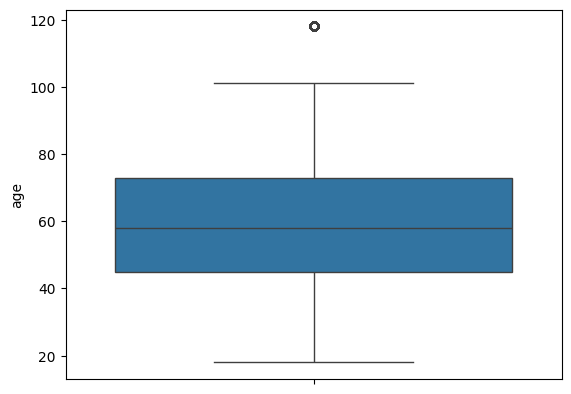

In [18]:
# Create box plot to find outliers 
sns.boxplot(profile["age"])

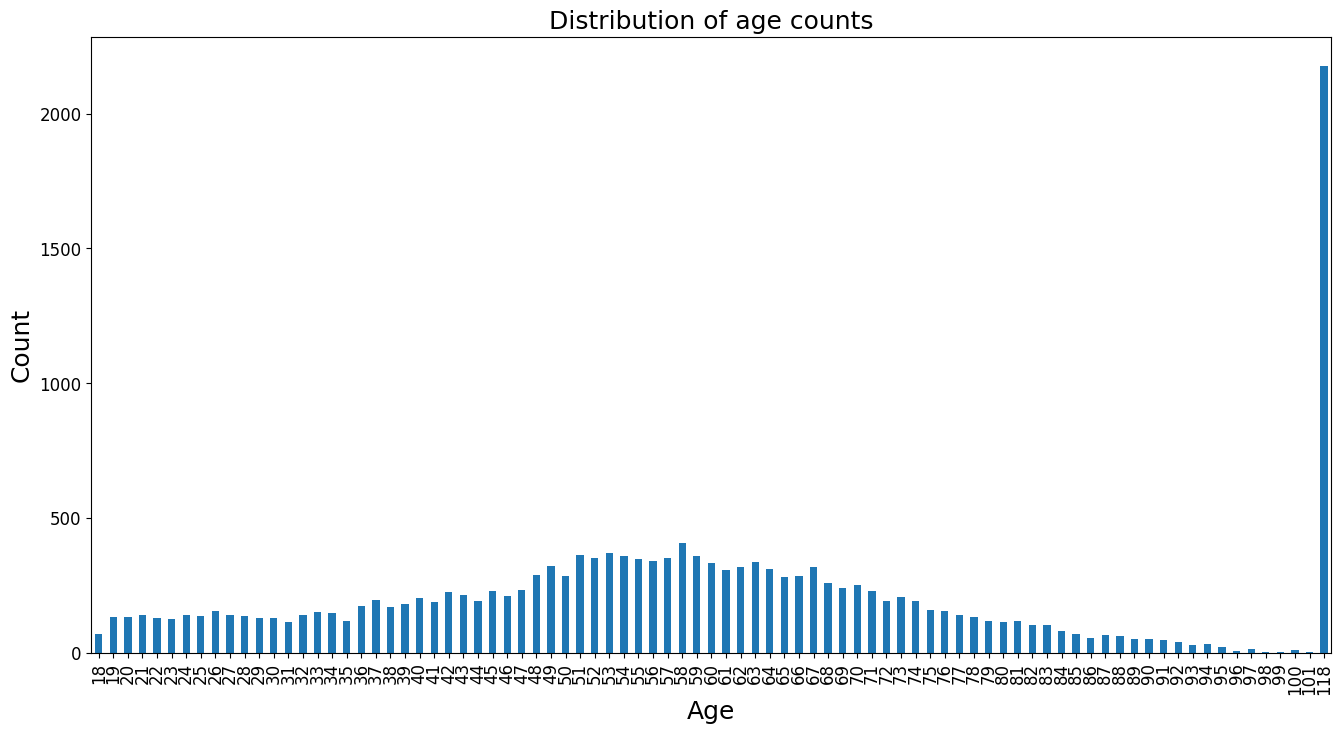

In [19]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(16,8), fontsize=12);
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts', fontsize=18)
plt.show()

The boxplot and histogram above show clearly outliers in the age. Obviously is the age 118 but then also we realise that the seems to be fewer numbers after age 80. It is possible that this group of customers don't really use the app or drink that much Starbucks beverages. These will be dropped as outliers

In [20]:
profile[profile['age']== 118].drop(['became_member_on' ,'customer_id'], axis=1) #Print values with age 118

,gender,age,customer_income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


#### Analyse the gender feature

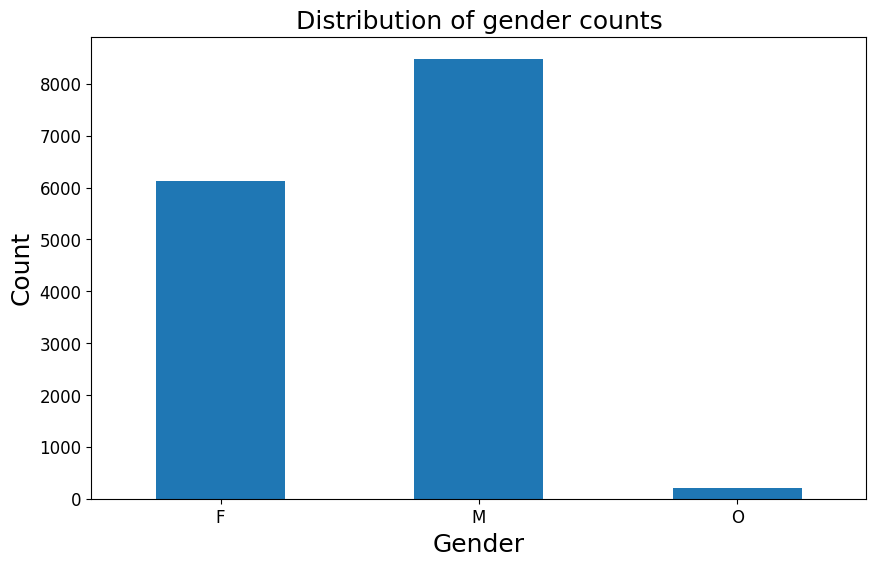

In [21]:
profile['gender'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,6), fontsize=12);
plt.xlabel('Gender', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title('Distribution of gender counts', fontsize=18)
plt.show()

We have more males than the other genders

In [22]:
profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'customer_income'], dtype='object')

In [23]:
# clean the profile dataframe
def clean_profile(df):
    """
    Clean the profile dataframe by:
    1. imputing missing values with median and gender with mode
    2. Age > 85 as outlier, remove from the dataset
    3. Classify ages in groups as: Under 20, 21-45, 46-60, 61-80
        
    Parameters
    ----------   
    df: dataframe
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df['age'].replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df['age'] < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df['age'] >= 20) & (df.age <= 45) , 'Age_group'] = '21-45'
    df.loc[(df['age'] >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df['age'] >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [24]:
profile = clean_profile(profile)

profile.head()

/var/folders/yv/5ykk6jzj43qb0f6x8fgvxyg40000gn/T/ipykernel_48755/2231963896.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].replace(118, np.nan , inplace=True)
/var/folders/yv/5ykk6jzj43qb0f6x8fgvxyg40000gn/T/ipykernel_48755/2231963896.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60


In [25]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            16014 non-null  object 
 1   customer_id       16014 non-null  object 
 2   became_member_on  16014 non-null  int64  
 3   customer_income   16014 non-null  float64
 4   Age_group         16014 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [26]:
profile.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
Age_group           0
dtype: int64

### Explote Transcript dataframe

In [27]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
#rename columns
transcript_cols = {'person':'customer_id'}
transcript = rename_columns(transcript, transcript_cols)

In [29]:
transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [30]:
transcript.shape

(306534, 4)

In [31]:
transcript.isnull().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

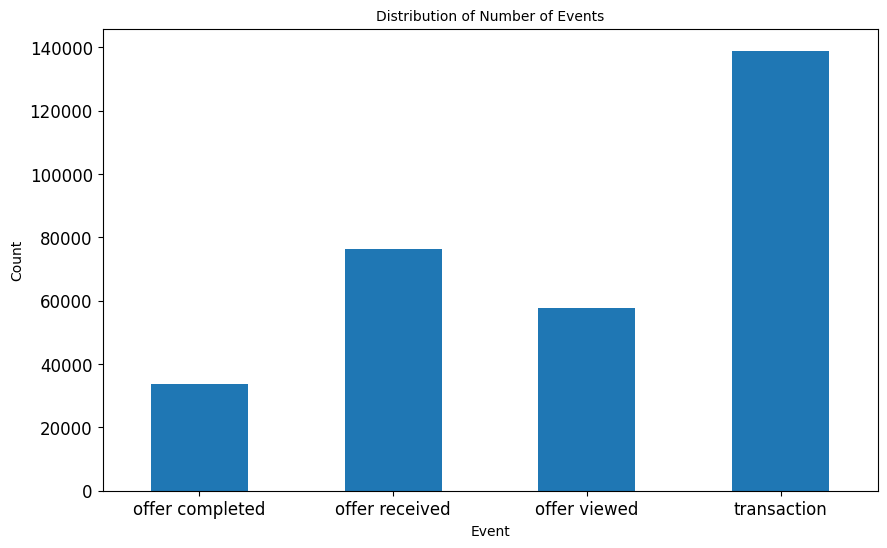

In [32]:
transcript['event'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,6), fontsize=12);
plt.xlabel('Event', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation='horizontal')
plt.title('Distribution of Number of Events', fontsize=10)
plt.show()

In [33]:
def clean_transcript(df):
    """
    Move the value column keys into new columns.
    
    Parameters
    ----------   
    df: dataframe
    
    Returns
    -------
    df: output dataframe as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [34]:
transcript = clean_transcript(transcript)

In [35]:
transcript.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


### Combine all the cleaned dtaframes

In [36]:
def combine_df(protfolio, profile, transcript):
    """
    Parameter: portfolio, profile, transcript - cleaned dataframes of the datasets
    Output: returns a combined dataframe of the three datasets
    """
    combined_df = pd.merge(portfolio, transcript, on="offer_id")
    combined_df = pd.merge(combined_df, profile, on="customer_id")

    return combined_df

In [37]:
combined_df = combine_df(portfolio, profile, transcript)
combined_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1e9420836d554513ab90eba98552d0a9,offer received,0,0.0,0.0,M,20170925,70000.0,21-45
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,02c083884c7d45b39cc68e1314fec56c,offer received,0,0.0,0.0,F,20160711,30000.0,21-45
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,676506bad68e4161b9bbaffeb039626b,offer received,0,0.0,0.0,M,20170515,92000.0,21-45
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,fe8264108d5b4f198453bbb1fa7ca6c9,offer received,0,0.0,0.0,F,20161009,93000.0,61-80


I want to answer some questions on the combined dataframe for insights:
1. What is the mean income of customers who use the app?
2. Which of the offers is the most used by the customers
3. What is the age distribution of the customers? Or the age groups?
4. The distribution of gender by age group?
5. The distribution of gender by the type of offer?

The average income is 65924.49 USD


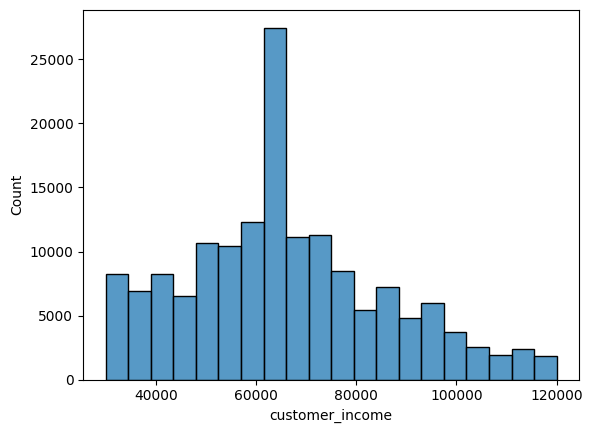

In [38]:
# 1. the average income of customers
sns.histplot(combined_df["customer_income"], bins=20);
print(f"The average income is {round(combined_df['customer_income'].mean(),2)} USD")

<Axes: title={'center': 'Distribution of offer types'}, xlabel='offer_type'>

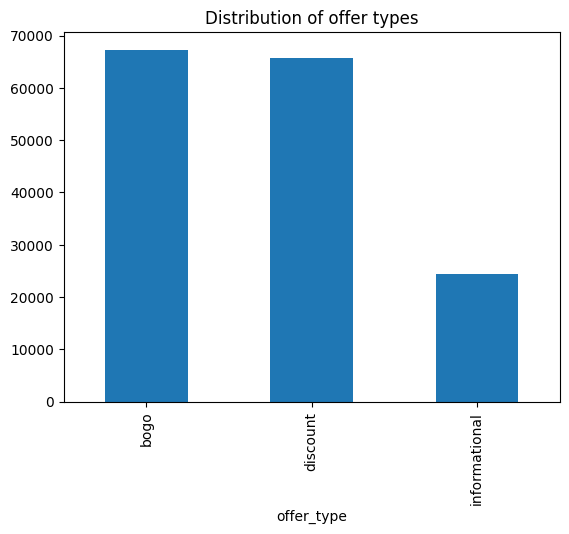

In [39]:
# 2. Which of the offers is the most used by the customers
combined_df.offer_type.value_counts().plot.bar(title='Distribution of offer types')

From the above plot, BOGO and discount purchases are the most used by the customers on the app


<Axes: title={'center': 'Distribution of age groups'}, xlabel='Age_group'>

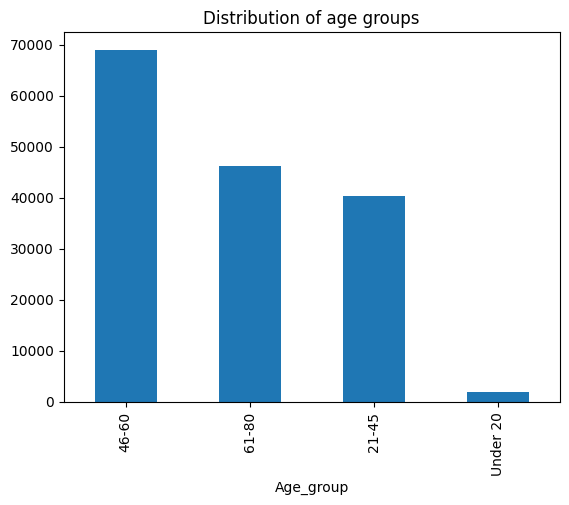

In [40]:
# 3. What is the age distribution of the customers? Or the age groups?
combined_df.Age_group.value_counts().plot.bar(title='Distribution of age groups')

From the plot, it may be suprising to see that middle-aged and older customers use the app more often than the younger population. However I think that usage is due to the fact that older people generally enjoy having coffee or tea than younger people and would spend much time having the shot of coffee through the app. 

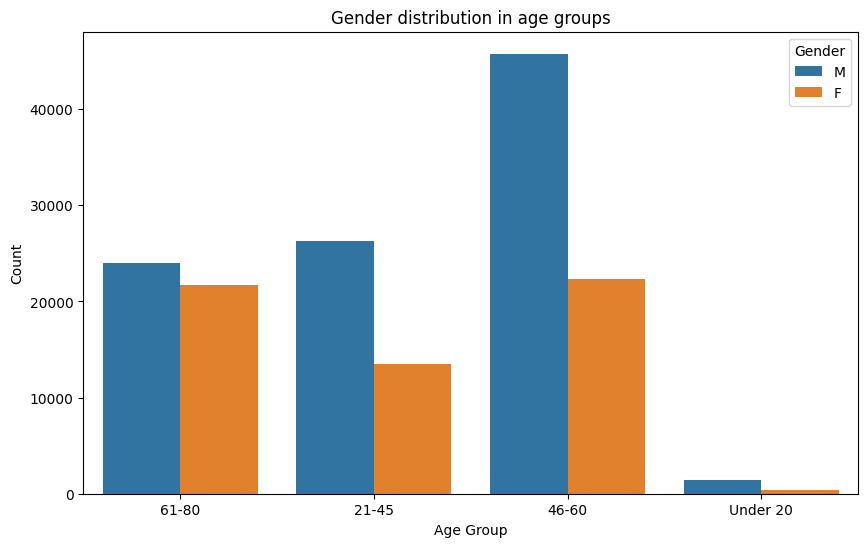

In [41]:
# 4. the distribution of gender by age group?
plt.figure(figsize=(10, 6))
sns.countplot(x= "Age_group", hue= "gender", data=combined_df[combined_df['gender'] != 'O'])
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

For each age group, male customers use the app more.

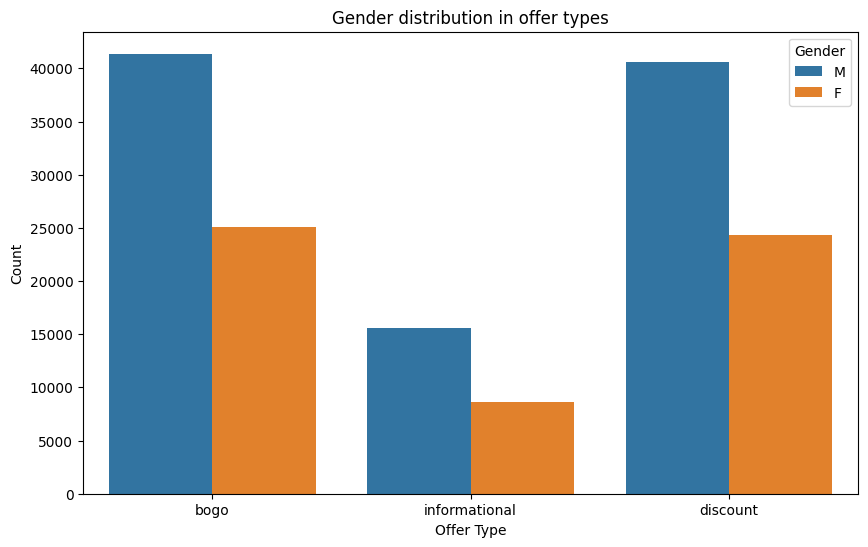

In [42]:
# 5. The distribution of gender by the type of offer?
plt.figure(figsize=(10, 6))
sns.countplot(x= "offer_type", hue= "gender", data=combined_df[combined_df['gender'] != 'O'])
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

This graph also indicates that across all three offer types, male customers use them more than female customers

<Axes: title={'center': 'Distribution of offers'}, xlabel='event'>

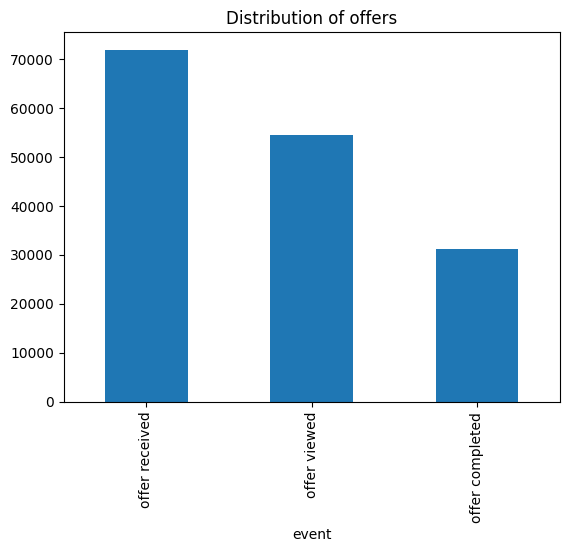

In [43]:
# Find what customers did when they received offers
combined_df["event"].value_counts().plot.bar(title="Distribution of offers")

What this plot shows is that a big fraction of offers received never have any actions taken on them. MOst cistomers view the offer and ignore them.

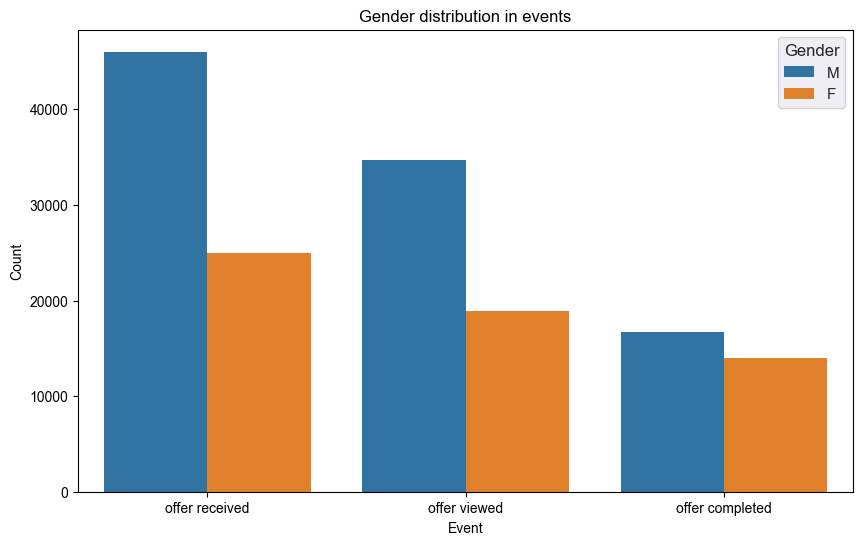

In [44]:
# Find actions to the offers that each gener received. Focus on just males and females
plt.figure(figsize=(10, 6))
sns.countplot(x= "event", hue= "gender", data=combined_df[combined_df['gender'] != 'O'])
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

We see that males receive the most offers because they are the biggest users too. However, most of them just view and ignore the offers, few going for the offer. In contrast, though in similar trends the same is for females, it seems that a bigger proportion of females that recieve offers go through with it.

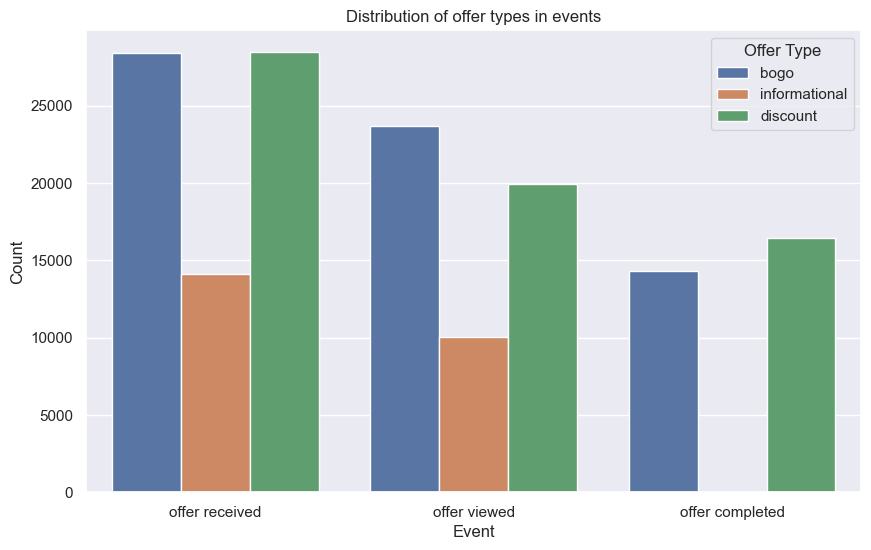

In [45]:
# Find what happens to the offers based on the offer type
plt.figure(figsize=(10, 6))
sns.countplot(x= "event", hue= "offer_type", data=combined_df[combined_df['gender'] != 'O'])
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

No customer has ever taken the informational offer. Generally, they tend to take the discount

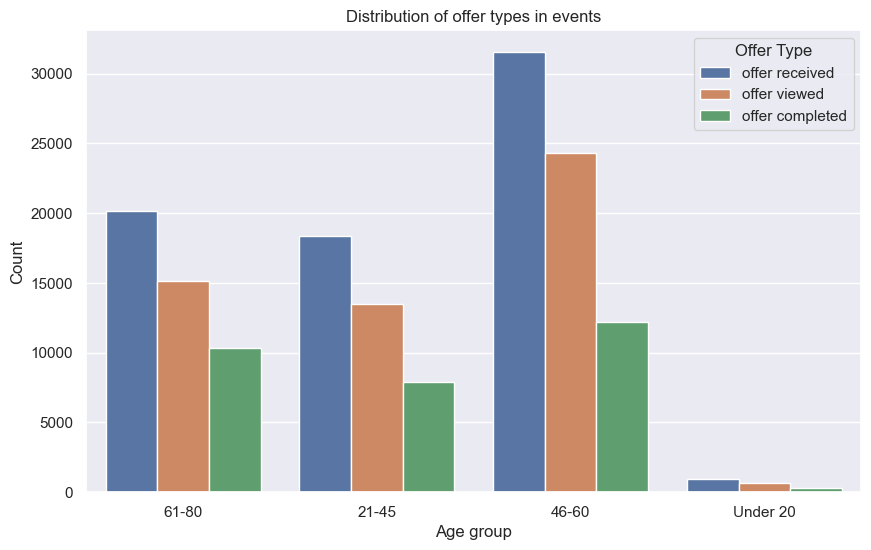

In [46]:
# Find what actions are taken by age group
plt.figure(figsize=(10, 6))
sns.countplot(x= "Age_group", hue= "event", data=combined_df[combined_df['gender'] != 'O'])
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Age group')
plt.legend(title='Offer Type')

Generally, customers from age 46 to 60 will go for the discounts!

### Predict the actions of a customer when they receive an offer

This is the time to build a machine learning model to predict how a customer will respodn on receipt of
an offer. But we need to prepare the data to optimise the model.
The data cotains categorial features (gender, offer_type, channel and age_group). We'll encode these features.
Also need to perform scaling and normalisation of the numerical data.

In [47]:
def prepare_data(df):
    categorical_features = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical_features) # Encode categorical features

    
    channels_dummies = df.channels.str.join("|").str.get_dummies()
    df = df.drop(columns="channels").join(channels_dummies) # transform channels column

    # tarnsform the became_member_on feature: get membership year and months
    df["became_member_on"] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new features for month and year
    df["membership_month"] = df["became_member_on"].apply(lambda x: x.day)
    df["membership_year"] = df["became_member_on"].apply(lambda x: x.year)
    df.drop('became_member_on',axis=1, inplace=True) # Drop became_member_on feature

    # transform customer ID
    cusids = df["customer_id"].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({"customer_id": c_mapping},inplace=True)

    # transform offer ID
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)

    # Scale and normalise numerical variables
    scaler = MinMaxScaler() # initialise scaler default=(0,1)
    numerical_features = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # encode event features, 1 = offer recived, 2=offer viewd 3=offer completed
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})

    return df

In [48]:
cleaned_df = prepare_data(combined_df)
cleaned_df.head()

/var/folders/yv/5ykk6jzj43qb0f6x8fgvxyg40000gn/T/ipykernel_48755/3874940826.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"customer_id": c_mapping},inplace=True)
/var/folders/yv/5ykk6jzj43qb0f6x8fgvxyg40000gn/T/ipykernel_48755/3874940826.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'offer_id': o_mapping},inplace=True)


,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,Age_group_21-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,membership_month,membership_year
0,1.0,0.5,0.571429,0,0,1,0.0,0.0,0.0,0.777778,...,False,False,True,False,1,1,1,0,9,2017
1,1.0,0.5,0.571429,0,1,1,0.0,0.0,0.0,0.444444,...,True,False,False,False,1,1,1,0,25,2017
2,1.0,0.5,0.571429,0,2,1,0.0,0.0,0.0,0.000000,...,True,False,False,False,1,1,1,0,11,2016
3,1.0,0.5,0.571429,0,3,1,0.0,0.0,0.0,0.688889,...,True,False,False,False,1,1,1,0,15,2017
4,1.0,0.5,0.571429,0,4,1,0.0,0.0,0.0,0.700000,...,False,False,True,False,1,1,1,0,9,2016


In [49]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157503 entries, 0 to 157502
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   offer_reward              157503 non-null  float64
 1   offer_difficulty          157503 non-null  float64
 2   offer_duration            157503 non-null  float64
 3   offer_id                  157503 non-null  int64  
 4   customer_id               157503 non-null  int64  
 5   event                     157503 non-null  int64  
 6   time                      157503 non-null  float64
 7   money_gained              157503 non-null  float64
 8   money_spent               157503 non-null  float64
 9   customer_income           157503 non-null  float64
 10  offer_type_bogo           157503 non-null  bool   
 11  offer_type_discount       157503 non-null  bool   
 12  offer_type_informational  157503 non-null  bool   
 13  gender_F                  157503 non-null  b

In [50]:
cleaned_df.shape

(157503, 26)

#### Training and Test data sets

We will split the data into training and test datasets, using 70% of data for training and 30% for test

In [51]:
# Get target data and independent data
X = cleaned_df.drop("event", axis=1)
y = cleaned_df["event"]

In [52]:
# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(f"Training set has {X_train.shape[0]} rows")
print(f"Test set has {X_test.shape[0]} rows")

Training set has 110252 rows
Test set has 47251 rows


In [53]:
# Distribution of the target cass in tthe data
y.squeeze().value_counts()

event
1    71863
2    54396
3    31244
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of the target class'}, xlabel='event'>

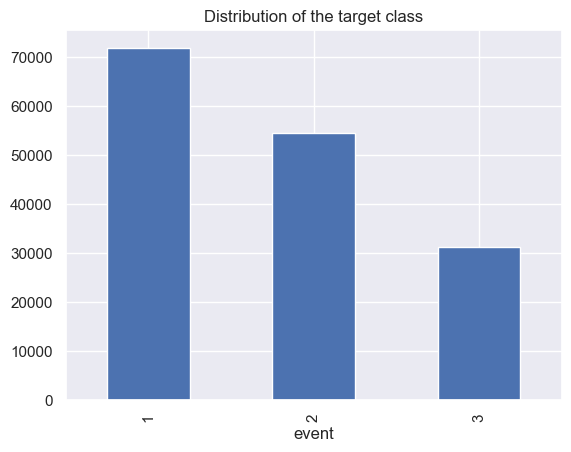

In [54]:
y.squeeze().value_counts().plot.bar(title='Distribution of the target class')

In [55]:
# Distribution of the target cass in training set
y_train.squeeze().value_counts()

event
1    50300
2    38139
3    21813
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of the class'}, xlabel='event'>

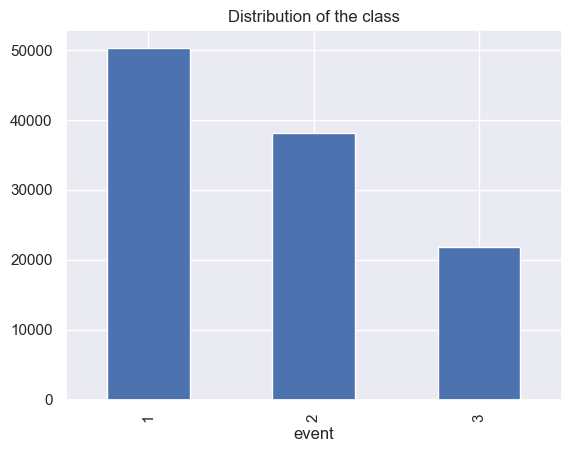

In [56]:
y_train.squeeze().value_counts().plot.bar(title='Distribution of the class')

#### Train the Clasifier

Create a benchmark model to compare if model is performing better than thator not
F1-score gives the best approach as it is the weighted avergae if the precsion and recall. Best value is 100
and worst is 0. The F1 score (in this case the fbeta) best habdles our data due to the class imbalance in the target feature for both training and test sets

In [57]:
def train_test(clf):
    """
    Parameter: clf that is the classifier
    returns the accuracy score fir the training set, f1 score for test and name of the class
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

##### LogisticRegression (Baseline or Benchmark Model)

In [60]:
lor = LogisticRegression(multi_class="multinomial", random_state=42, max_iter=100) #use multinomial class due to non-binary class in target
lor_train_f1, lor_test_f1, lor_model = train_test(lor)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [61]:
benchmark = pd.DataFrame({'Benchmark Model': [ lor_model], 'train F1 score':[lor_train_f1], 'test F1 score': [lor_test_f1]})

In [62]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,LogisticRegression,45.392374,45.577871


Our benchmark model is the Logisticregression model. We notice that it has weak f1 scores. 
It will be compared to a few models namely: KNeighboursClassifier, RandomForestClassifier,
AdaBoost and GradedBoost for the best model outcome

#### KNeighboursClassifier

In [63]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn_train_f1, knn_test_f1, knn_model = train_test(knn)

#### RandomForestClassifier

In [64]:
rfc = RandomForestClassifier(random_state = 42)
rfc_train_f1, rfc_test_f1, rfc_model = train_test(rfc)

#### AdaBoostClassifer

In [65]:
abc = AdaBoostClassifier(random_state=42)
abc_train_f1, abc_test_f1, abc_model = train_test(abc)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


#### GradedBoostedClassifier

In [66]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_train_f1, gbc_test_f1, gbc_model = train_test(gbc)

### Model Comparison

In [67]:
models = {'Model': ['Logistic Regression (Benchmark)', knn_model, rfc_model, abc_model, gbc_model], 
          'train F1 score ':[lor_train_f1, knn_train_f1, rfc_train_f1, abc_train_f1, gbc_train_f1], 
          'test F1 score': [lor_test_f1 , knn_test_f1, rfc_test_f1, abc_test_f1, gbc_test_f1] }
          
comparison_table = pd.DataFrame(models)

In [68]:
comparison_table

,Model,train F1 score,test F1 score
0,Logistic Regression (Benchmark),45.392374,45.577871
1,KNeighborsClassifier,52.889743,31.006751
2,RandomForestClassifier,94.690346,71.890542
3,AdaBoostClassifier,91.271814,91.339866
4,GradientBoostingClassifier,92.330298,92.389579


The comparison table above shows the test and train f1 score for the benchmark model and the other tested models. It appears that the gradedboostedclassifier has the highest f1 score for both train and test data, followed by AdaBoostClassifier and RandomForestClassifier. Seeing as we have very high f1 sores for a non-sensitive data, that is sufficient to predict whether a customer will repondd to an offer

#### Feature Importance

I want to see how the features play a role in the model's performance so I'll plot a feature importance. this is great for business decisions.

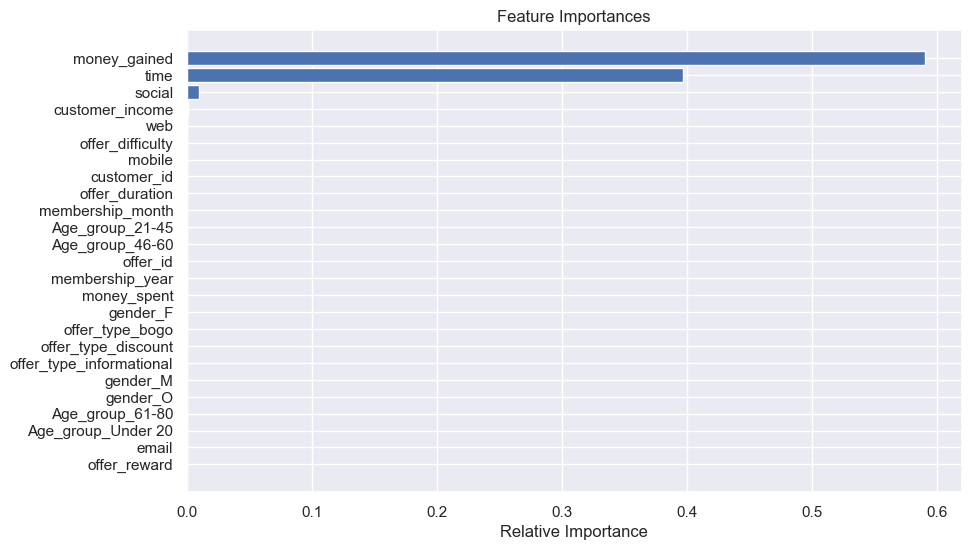

In [69]:
feature_importances = gbc.feature_importances_

# Plot feature importances
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We see the feature importance plot that money_gained, time (duration) of the offer to be open and social media channels are the most important features in the performance of the model. This will inform Starbucks about communication strategy, look at revenue and duration of their offers.